<a href="https://colab.research.google.com/github/Susena-V/SNA_Project/blob/main/Project_Round2_TaskBMathOverflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

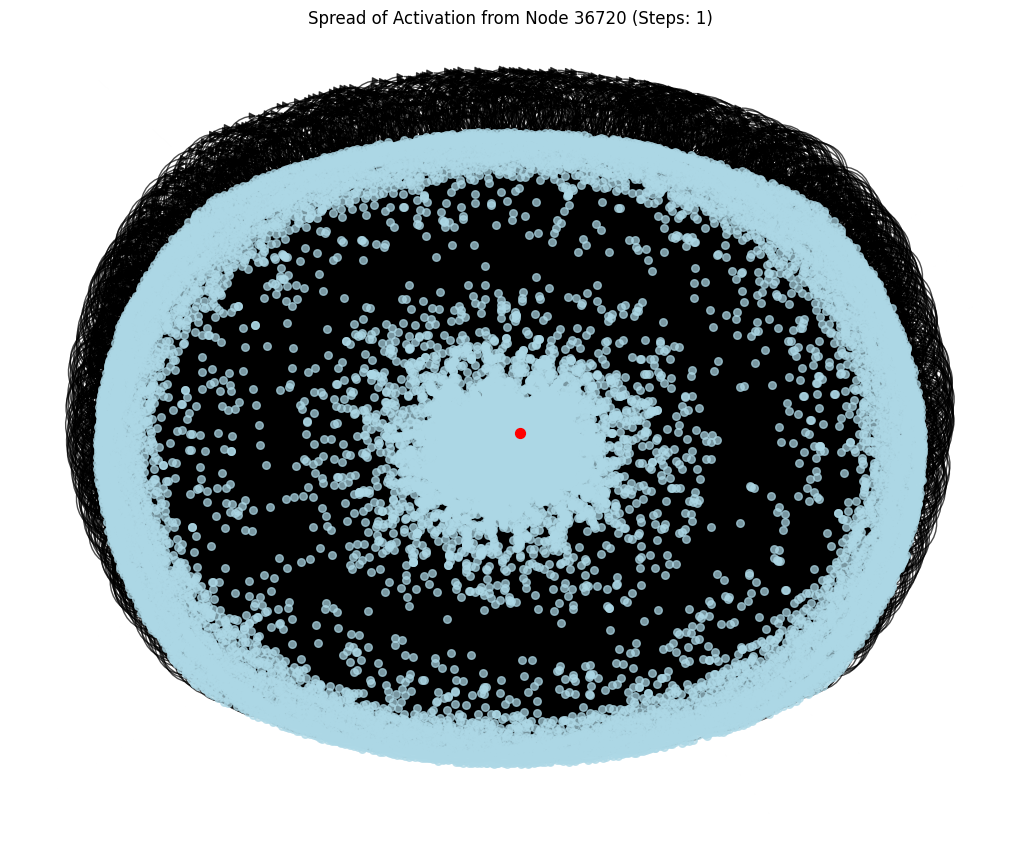

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import random
import numpy as np

# Load the graph from sample.txt, ignoring the timestamp column
G = nx.DiGraph()
with open("/content/sx-mathoverflow.txt", "r") as f:
    for line in f:
        u, v, _ = line.strip().split()
        G.add_edge(int(u), int(v))

# Assign normalized random activation probabilities for each node's outgoing edges
activation_prob = {}
for node in G.nodes():
    neighbors = list(G.successors(node))
    if neighbors:
        probs = np.random.rand(len(neighbors))
        probs /= probs.sum()  # Normalize to sum = 1
        activation_prob[node] = dict(zip(neighbors, probs))
    else:
        activation_prob[node] = {}

# New version of independent_cascade to return full timeline
def independent_cascade_timeline(G, seed, activation_prob):
    active = set([seed])
    newly_active = set([seed])
    steps = 0
    timeline = [1]  # Start with just the seed

    while newly_active:
        next_newly_active = set()
        for node in newly_active:
            for neighbor in G.successors(node):
                if neighbor not in active:
                    prob = activation_prob.get(node, {}).get(neighbor, 0)
                    if random.random() <= prob:
                        next_newly_active.add(neighbor)
        newly_active = next_newly_active
        active.update(newly_active)
        steps += 1
        timeline.append(len(active))

    return steps, len(active), timeline

# Run 5 random seed experiments and collect timelines
random_seeds = random.sample(list(G.nodes()), 5)
all_timelines = []
step_results = []

print("Running ICM for 5 random seed nodes:")
for seed in random_seeds:
    steps, total_infected, timeline = independent_cascade_timeline(G, seed, activation_prob)
    print(f"Seed Node: {seed}, Steps: {steps}, Infected Nodes: {total_infected}")
    all_timelines.append(timeline)
    step_results.append(steps)

avg_steps = sum(step_results) / len(step_results)
print(f"\nAverage number of steps over 5 runs: {avg_steps:.2f}")

# Plot all 5 timelines
for idx, timeline in enumerate(all_timelines):
    plt.plot(range(len(timeline)), timeline, label=f"Seed {idx+1}")

plt.title("Spread of Infection Over Time (5 ICM Runs)")
plt.xlabel("Step")
plt.ylabel("Infected Nodes")
plt.legend()
plt.grid(True)
plt.show()


Running ICM from all nodes (this might take a minute)...


100%|██████████| 24818/24818 [00:08<00:00, 3030.27it/s]


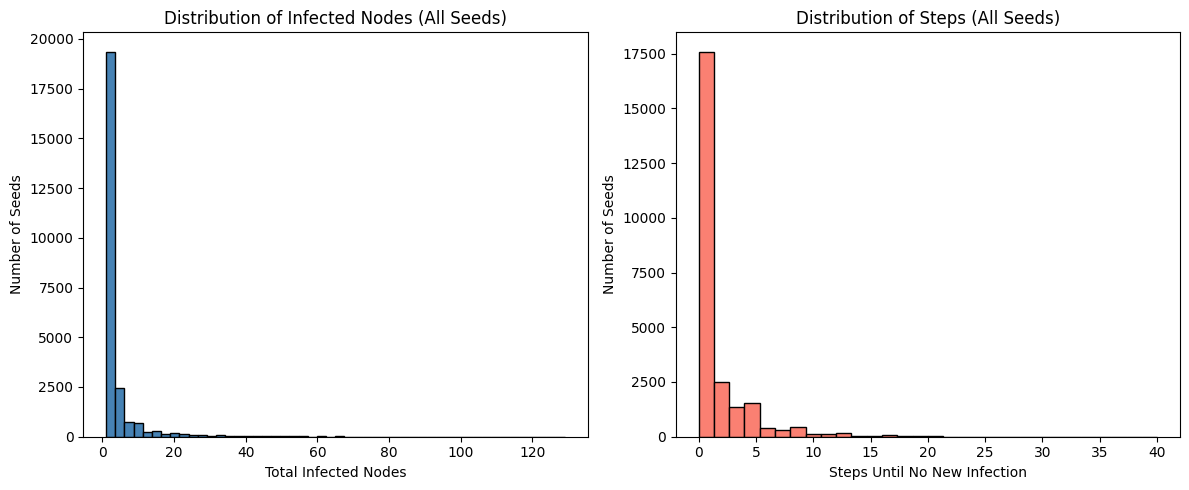


Top 10 most influential seed nodes:
Node 9468: infected 129 nodes
Node 12914: infected 128 nodes
Node 58719: infected 128 nodes
Node 968: infected 124 nodes
Node 966: infected 120 nodes
Node 13923: infected 119 nodes
Node 11638: infected 118 nodes
Node 56099: infected 117 nodes
Node 4672: infected 116 nodes
Node 4017: infected 111 nodes


In [ ]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm  # progress bar for large graphs

# Load graph
G = nx.DiGraph()
with open("/content/sx-mathoverflow.txt", "r") as f:
    for line in f:
        u, v, _ = line.strip().split()
        G.add_edge(int(u), int(v))

# Assign normalized random activation probabilities per outgoing edges
activation_prob = {}
for node in G.nodes():
    neighbors = list(G.successors(node))
    if neighbors:
        probs = np.random.rand(len(neighbors))
        probs /= probs.sum()
        activation_prob[node] = dict(zip(neighbors, probs))
    else:
        activation_prob[node] = {}

# ICM function with timeline
def independent_cascade(G, seed, activation_prob):
    active = set([seed])
    newly_active = set([seed])
    steps = 0

    while newly_active:
        next_newly_active = set()
        for node in newly_active:
            for neighbor in G.successors(node):
                if neighbor not in active:
                    prob = activation_prob.get(node, {}).get(neighbor, 0)
                    if random.random() <= prob:
                        next_newly_active.add(neighbor)
        newly_active = next_newly_active
        active.update(newly_active)
        steps += 1 if newly_active else 0

    return steps, len(active)

# Run ICM for all nodes
all_steps = []
all_infected = []

print("Running ICM from all nodes (this might take a minute)...")
for node in tqdm(G.nodes()):
    steps, infected = independent_cascade(G, node, activation_prob)
    all_steps.append(steps)
    all_infected.append(infected)

# Plot: histogram of total infected nodes
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(all_infected, bins=50, color='steelblue', edgecolor='black')
plt.title("Distribution of Infected Nodes (All Seeds)")
plt.xlabel("Total Infected Nodes")
plt.ylabel("Number of Seeds")

# Plot: histogram of steps
plt.subplot(1, 2, 2)
plt.hist(all_steps, bins=30, color='salmon', edgecolor='black')
plt.title("Distribution of Steps (All Seeds)")
plt.xlabel("Steps Until No New Infection")
plt.ylabel("Number of Seeds")

plt.tight_layout()
plt.show()

# Optional: show top spreaders
top_spreaders = sorted(zip(G.nodes(), all_infected), key=lambda x: -x[1])[:10]
print("\nTop 10 most influential seed nodes:")
for node, infected in top_spreaders:
    print(f"Node {node}: infected {infected} nodes")


## Some changes

Results for the Network:
Average Steps: 1.0
Max Nodes Activated: 1


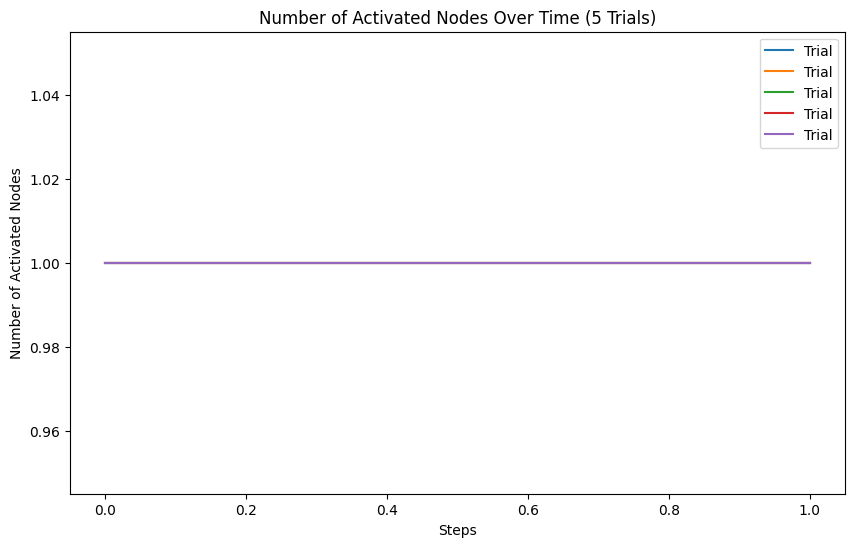

In [6]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np

# Independent Cascade Model (ICM) for Temporal Networks
def temporal_independent_cascade(G, start_node, activation_probabilities, edge_times):
    activated = set([start_node])
    new_activated = set([start_node])
    steps = 0
    all_activated_nodes = {start_node}
    current_time = 0  # Time starts from 0
    activated_over_time = {steps: len(activated)}  # Store the number of activated nodes at each step

    while new_activated:
        steps += 1
        current_activated = new_activated.copy()
        new_activated = set()

        for node in current_activated:
            neighbors = list(G.neighbors(node))  # Directed edges from node to neighbors
            for neighbor in neighbors:
                if neighbor not in activated:
                    # Check if the edge is active at the current time
                    edge_key = (node, neighbor)
                    if edge_key in edge_times and edge_times[edge_key] <= current_time:
                        # Check if the node gets activated based on the assigned probability
                        activation_prob = activation_probabilities[node][neighbor]
                        if random.random() < activation_prob:
                            activated.add(neighbor)
                            new_activated.add(neighbor)
                            all_activated_nodes.add(neighbor)

        # Store the number of activated nodes at the current step
        activated_over_time[steps] = len(activated)

        # Update time after each step
        current_time += 1

    return steps, all_activated_nodes, activated_over_time

# Function to assign random probabilities
def assign_activation_probabilities(G):
    activation_probabilities = {}
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        total_prob = 0
        activation_probabilities[node] = {}
        for neighbor in neighbors:
            # Random probability between 0 and 1 for each edge
            prob = random.random()
            activation_probabilities[node][neighbor] = prob
            total_prob += prob

        # Normalize so that sum of probabilities equals 1
        for neighbor in neighbors:
            activation_probabilities[node][neighbor] /= total_prob

    return activation_probabilities

# Function to run ICM on the network and calculate average steps
def run_icm_on_network(G, edge_times, num_trials=5):
    avg_steps = 0
    max_nodes_activated = 0
    activated_over_time_all_trials = []  # To store activated over time for plotting

    for _ in range(num_trials):
        # Assign random activation probabilities
        activation_probabilities = assign_activation_probabilities(G)

        # Start from a random node in the network
        start_node = random.choice(list(G.nodes()))

        # Apply ICM and get the steps, number of nodes activated, and activated over time
        steps, activated_nodes, activated_over_time = temporal_independent_cascade(G, start_node, activation_probabilities, edge_times)

        avg_steps += steps
        max_nodes_activated = max(max_nodes_activated, len(activated_nodes))

        # Store the activated over time data for plotting
        activated_over_time_all_trials.append(activated_over_time)

    # Calculate the average number of steps over the trials
    avg_steps /= num_trials
    return avg_steps, max_nodes_activated, activated_over_time_all_trials

# Load the temporal network from the file
G = nx.DiGraph()
edge_times = {}  # Store the activation times for edges

with open("/content/sx-mathoverflow.txt", "r") as f:
    for line in f:
        u, v, t = line.strip().split()
        u, v, t = int(u), int(v), int(t)  # Convert to integers
        G.add_edge(u, v)
        edge_times[(u, v)] = t  # Store the activation time for the edge

# Run ICM test on the single network
avg_steps, max_nodes_activated, activated_over_time_all_trials = run_icm_on_network(G, edge_times)

# Print the results
print(f"Results for the Network:")
print(f"Average Steps: {avg_steps}")
print(f"Max Nodes Activated: {max_nodes_activated}")

# Example of visualizing the spread
start_node = random.choice(list(G.nodes()))
activation_probabilities = assign_activation_probabilities(G)
steps, activated_nodes, activated_over_time = temporal_independent_cascade(G, start_node, activation_probabilities, edge_times)


# Plot the number of activated nodes over time for each trial
plt.figure(figsize=(10, 6))
for activated_over_time in activated_over_time_all_trials:
    plt.plot(list(activated_over_time.keys()), list(activated_over_time.values()), label='Trial')

plt.xlabel('Steps')
plt.ylabel('Number of Activated Nodes')
plt.title(f"Number of Activated Nodes Over Time (5 Trials)")
plt.legend()
plt.show()


Seeds used: ['13469', '550', '19550', '27043', '50511']
Average number of steps: 1.20


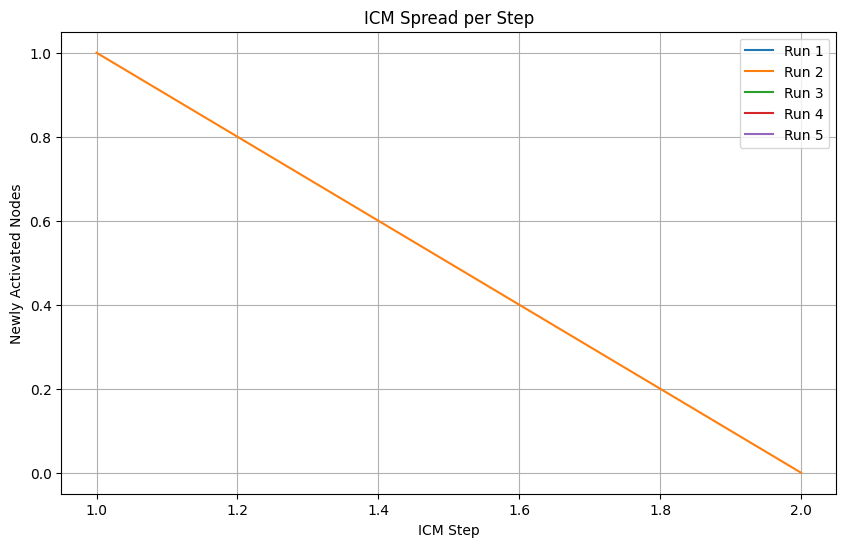

In [3]:
import networkx as nx
import random
import matplotlib.pyplot as plt
from collections import defaultdict

# === Load Graph from Temporal File (ignore timestamps) ===
def load_static_graph(file_path):
    G = nx.DiGraph()
    with open(file_path, 'r') as f:
        for line in f:
            u, v, _ = line.strip().split()
            G.add_edge(u, v)
    return G

# === Assign Activation Probabilities (Sum of Outgoing = 1) ===
def assign_activation_probabilities(G):
    for node in G.nodes():
        neighbors = list(G.successors(node))
        if not neighbors:
            continue
        weights = [random.random() for _ in neighbors]
        total = sum(weights)
        for i, nbr in enumerate(neighbors):
            G[node][nbr]['prob'] = weights[i] / total

# === Standard ICM Simulation ===
def run_icm(G, seed):
    active = set([seed])
    newly_active = set([seed])
    steps = []

    while newly_active:
        next_active = set()
        for node in newly_active:
            for neighbor in G.successors(node):
                if neighbor not in active:
                    prob = G[node][neighbor]['prob']
                    if random.random() <= prob:
                        next_active.add(neighbor)
        steps.append(len(next_active))
        newly_active = next_active
        active.update(newly_active)
    return steps

# === Run Multiple ICM Simulations ===
def run_multiple_icm(G, runs=5):
    results = []
    seeds = random.sample(list(G.nodes()), runs)
    print("Seeds used:", seeds)

    for seed in seeds:
        steps = run_icm(G, seed)
        results.append(steps)

    return results

# === Plotting ===
def plot_runs(step_lists):
    plt.figure(figsize=(10, 6))
    for i, steps in enumerate(step_lists):
        plt.plot(range(1, len(steps) + 1), steps, label=f'Run {i + 1}')
    plt.xlabel('ICM Step')
    plt.ylabel('Newly Activated Nodes')
    plt.title('ICM Spread per Step')
    plt.legend()
    plt.grid(True)
    plt.show()

# === Main ===
file_path = '/content/sx-mathoverflow.txt'  # Your actual file path
G = load_static_graph(file_path)
assign_activation_probabilities(G)
results = run_multiple_icm(G)

avg_steps = sum(len(r) for r in results) / len(results)
print(f"Average number of steps: {avg_steps:.2f}")

plot_runs(results)



--- All ICM Runs ---
Run 1: Seed=15799, Total Activated=1, Steps=1
Run 2: Seed=473, Total Activated=2, Steps=2
Run 3: Seed=69782, Total Activated=1, Steps=1
Run 4: Seed=27554, Total Activated=1, Steps=1
Run 5: Seed=4422, Total Activated=1, Steps=1

=== Best Run Selected ===
Seed: 473
Total Activated: 2
Steps Taken: 2


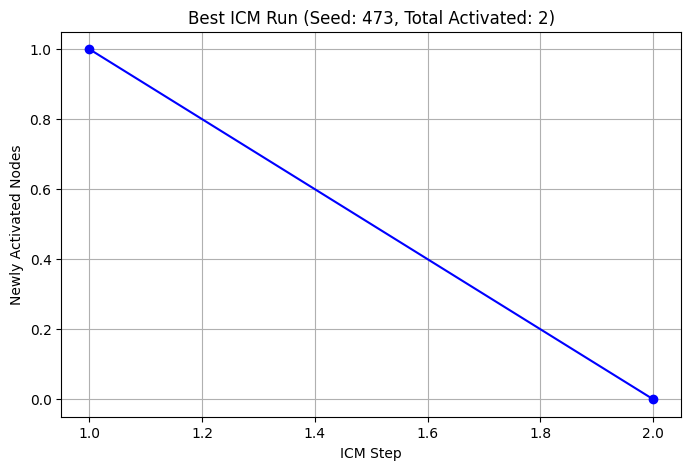

In [5]:
import networkx as nx
import random
import matplotlib.pyplot as plt
from collections import defaultdict

# === Load Graph ===
def load_static_graph(file_path):
    G = nx.DiGraph()
    with open(file_path, 'r') as f:
        for line in f:
            u, v, _ = line.strip().split()
            G.add_edge(u, v)
    return G

# === Assign Activation Probabilities ===
def assign_activation_probabilities(G):
    for node in G.nodes():
        neighbors = list(G.successors(node))
        if not neighbors:
            continue
        weights = [random.random() for _ in neighbors]
        total = sum(weights)
        for i, nbr in enumerate(neighbors):
            G[node][nbr]['prob'] = weights[i] / total

# === Standard ICM Simulation ===
def run_icm(G, seed):
    active = set([seed])
    newly_active = set([seed])
    steps = []

    while newly_active:
        next_active = set()
        for node in newly_active:
            for neighbor in G.successors(node):
                if neighbor not in active:
                    prob = G[node][neighbor]['prob']
                    if random.random() <= prob:
                        next_active.add(neighbor)
        steps.append(len(next_active))
        newly_active = next_active
        active.update(newly_active)
    return steps, active

# === Run Multiple ICM Simulations ===
def run_multiple_icm(G, runs=5):
    results = []
    seeds = random.sample(list(G.nodes()), runs)

    for seed in seeds:
        steps, activated = run_icm(G, seed)
        result = {
            'seed': seed,
            'steps': steps,
            'total_activated': len(activated)
        }
        results.append(result)

    return results

# === Select Best Run ===
def select_best_run(results):
    # Sort by max activated (desc), then by shortest steps (asc)
    return sorted(results, key=lambda r: (-r['total_activated'], len(r['steps'])))[0]

# === Plot Single Best Run ===
def plot_best_run(best_run):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(best_run['steps']) + 1), best_run['steps'], marker='o', color='blue')
    plt.xlabel('ICM Step')
    plt.ylabel('Newly Activated Nodes')
    plt.title(f"Best ICM Run (Seed: {best_run['seed']}, Total Activated: {best_run['total_activated']})")
    plt.grid(True)
    plt.show()

# === Main ===
file_path = '/content/sx-mathoverflow.txt'  # Your file path here
G = load_static_graph(file_path)
assign_activation_probabilities(G)
results = run_multiple_icm(G)

# Print all 5 runs
print("\n--- All ICM Runs ---")
for i, r in enumerate(results):
    print(f"Run {i+1}: Seed={r['seed']}, Total Activated={r['total_activated']}, Steps={len(r['steps'])}")

# Get and plot best run
best_run = select_best_run(results)
print(f"\n=== Best Run Selected ===\nSeed: {best_run['seed']}\nTotal Activated: {best_run['total_activated']}\nSteps Taken: {len(best_run['steps'])}")
plot_best_run(best_run)


## Yalini's Code

Running ICM for 5 random seed nodes:
Seed Node: 477, Steps: 0, Infected Nodes: 1
Seed Node: 12438, Steps: 0, Infected Nodes: 1
Seed Node: 8165, Steps: 9, Infected Nodes: 12
Seed Node: 58789, Steps: 1, Infected Nodes: 2
Seed Node: 22306, Steps: 0, Infected Nodes: 1

Best Run Selected: Seed=8165, Steps=9, Total Infected=12


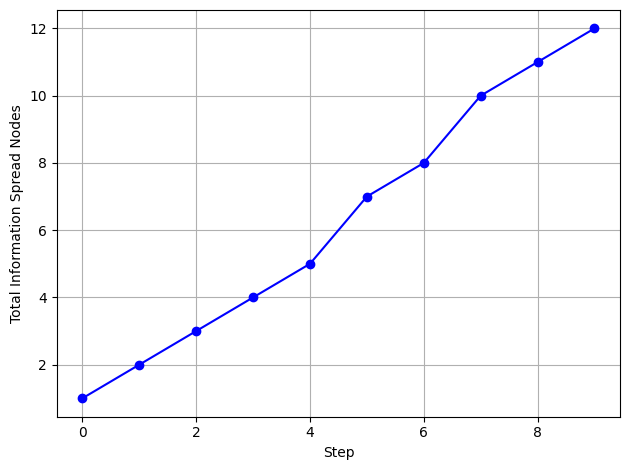

In [8]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt

# === Step 1: Load Graph (ignoring timestamps) ===
def load_static_graph(file_path):
    G = nx.DiGraph()
    with open(file_path, 'r') as f:
        for line in f:
            u, v, _ = line.strip().split()
            G.add_edge(u, v)
    return G

# === Step 2: Assign activation probabilities (normalized per node) ===
def assign_activation_probabilities(G):
    activation_prob = {}
    for node in G.nodes():
        neighbors = list(G.successors(node))
        if neighbors:
            probs = np.random.rand(len(neighbors))
            probs /= probs.sum()
            activation_prob[node] = dict(zip(neighbors, probs))
        else:
            activation_prob[node] = {}
    return activation_prob

# === Step 3: ICM with timeline ===
def independent_cascade(G, seed, activation_prob):
    active = set([seed])
    newly_active = set([seed])
    steps = 0
    timeline = [1]  # initial seed active

    while newly_active:
        next_newly_active = set()
        for node in newly_active:
            for neighbor in G.successors(node):
                if neighbor not in active:
                    prob = activation_prob.get(node, {}).get(neighbor, 0)
                    if random.random() <= prob:
                        next_newly_active.add(neighbor)
        newly_active = next_newly_active
        active.update(newly_active)
        if newly_active:
            steps += 1
            timeline.append(len(active))

    return steps, len(active), timeline, seed

# === Step 4: Run for 5 random seeds ===
def run_icm_on_graph(G, runs=5):
    activation_prob = assign_activation_probabilities(G)
    seeds = random.sample(list(G.nodes()), runs)
    results = []

    print("Running ICM for 5 random seed nodes:")
    for seed in seeds:
        steps, infected, timeline, used_seed = independent_cascade(G, seed, activation_prob)
        print(f"Seed Node: {used_seed}, Steps: {steps}, Infected Nodes: {infected}")
        results.append({
            'seed': used_seed,
            'steps': steps,
            'infected': infected,
            'timeline': timeline
        })

    return results

# === Step 5: Select and plot best run ===
def plot_best_run(results):
    best_run = sorted(results, key=lambda r: (-r['infected'], r['steps']))[0]
    print(f"\nBest Run Selected: Seed={best_run['seed']}, Steps={best_run['steps']}, Total Infected={best_run['infected']}")

    plt.plot(range(len(best_run['timeline'])), best_run['timeline'], marker='o', color='blue')
    plt.xlabel("Step")
    plt.ylabel("Total Information Spread Nodes")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Main ===
file_path = '/content/sx-mathoverflow.txt'
G = load_static_graph(file_path)
results = run_icm_on_graph(G, runs=5)
plot_best_run(results)
